In [13]:
# bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost.core import CatBoostRegressor
from statsmodels.api import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.stats as stats

In [2]:
# dados
df = pd.read_csv('../data/insurance-encoded.csv', sep=',', encoding='utf-8')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [3]:
# variaveis
x = df.drop('charges', axis=1)
y = df.charges
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y,test_size=0.3,random_state=10)

## XGBoost

In [5]:
# modelo
xgb = XGBRegressor(random_state=10, n_estimators=20, max_depth=2).fit(x_treino, y_treino)
y_prev = xgb.predict(x_teste)
residuos = y_teste - y_prev

In [6]:
# teste de normalidade dos residuos
"""
Ho = distribuição normal: p > 0.05
Ha = distribuição != normal : p <= 0.05
"""
_, p = stats.shapiro(residuos)
if p > 0.05:
    print(f'Valor de p: {p} - Distribuição Normal')
else:
    print(f'Valor de p: {p} - Distribuição não Normal')

Valor de p: 1.7709243692313096e-30 - Distribuição não Normal


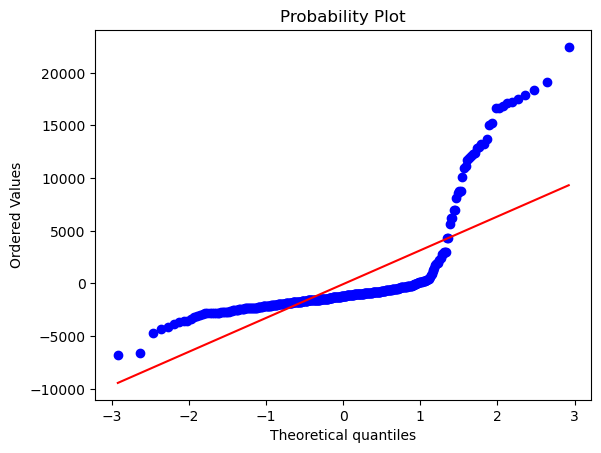

In [7]:
# plot Q-Q dos residuos
stats.probplot(residuos, dist='norm', plot=plt)
plt.show()

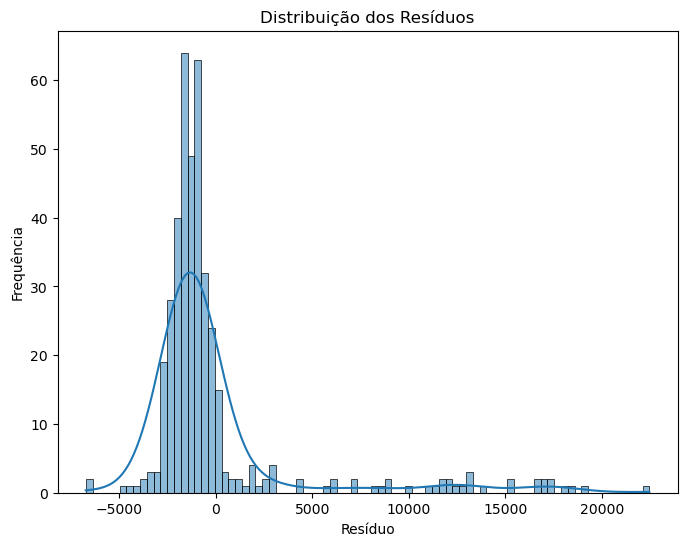

In [8]:
# plot frequencia
plt.figure(figsize=(8,6))
sns.histplot(residuos, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

In [15]:
# teste de homocedasticidade
"""
H0 = existe homocedasticidade: p > 0.05
Ha = não existe homocedasticidade: p <= 0.05
"""
x_teste_constante = add_constant(x_teste) # adicionando intercepto ao dados

estatistica, p, f, fp = het_breuschpagan(residuos, x_teste_constante)
if p <= 0.05:
    print(f'Não existe homocedasticidade. valor de p = {p}')
else:
    print(f'Existe homocedasticidade. valor de p = {p}')

Existe homocedasticidade. valor de p = 0.5659460069286957


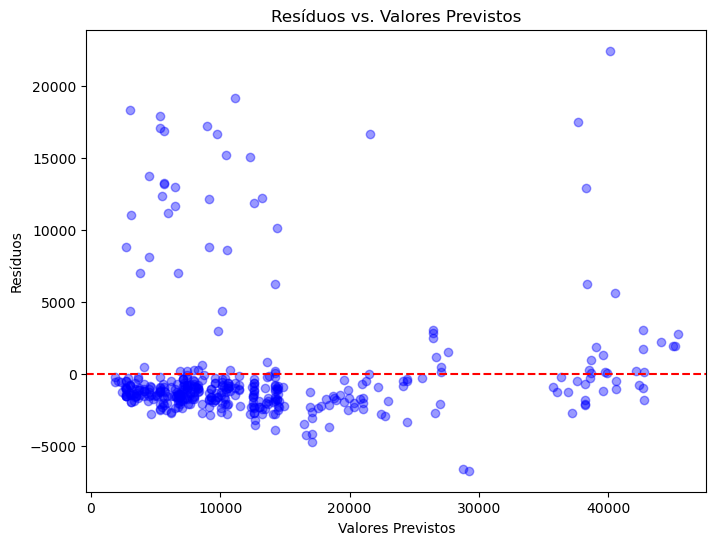

In [23]:
# plot homocedasticidade
plt.figure(figsize=(8,6))
plt.scatter(y_prev, residuos, color='blue', alpha=.4)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs. Valores Previstos')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.show()

In [24]:
# outliers

std_residuos = np.std(residuos) # desvio padrao dos residuos
residuos_padronizados = residuos / std_residuos
outliers = residuos_padronizados[(residuos_padronizados > 3) | (residuos_padronizados < -3)]

# outliers detectados
print(f"Outliers detectados (fora do intervalo [-3, 3]):\n{outliers}")

# maiores e menores resíduos padronizados
print(f"Maior resíduo padronizado: {residuos_padronizados.max()}")
print(f"Menor resíduo padronizado: {residuos_padronizados.min()}")

Outliers detectados (fora do intervalo [-3, 3]):
658     3.904752
520     3.570524
387     4.492554
539     3.535251
688     4.044150
1300    5.268765
102     4.305345
1328    4.010094
524     3.917516
1008    4.208483
1195    3.098863
858     3.224383
305     3.044932
819     4.102966
1123    3.109158
1039    3.956233
34      3.023322
Name: charges, dtype: float64
Maior resíduo padronizado: 5.268765253985156
Menor resíduo padronizado: -1.5829998577030506


In [28]:
# ausencia de multicolinearidade
"""
somente entre as independentes
considerada multicolinearidade quando r > 0.9
"""
corr_matrix = x.corr(method='pearson')
corr_matrix

,age,sex,bmi,children,smoker,region
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002127
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.004588
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.157566
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.016569
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.002181
region,0.002127,0.004588,0.157566,0.016569,-0.002181,1.000000


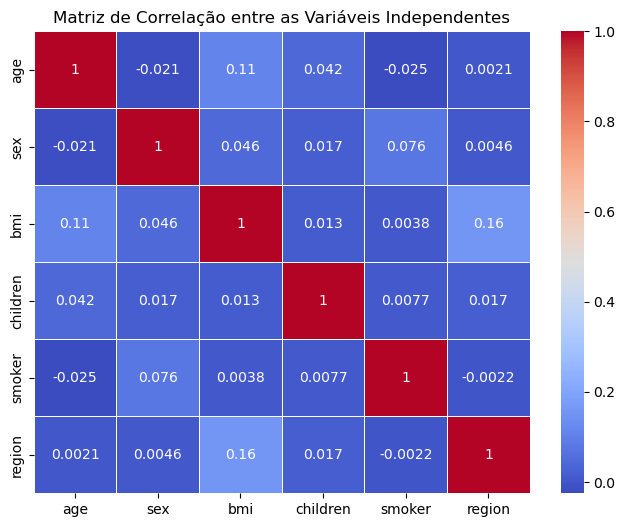

Pares de variáveis com correlação maior que 0.9:
 Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region]
Index: []


In [30]:
# plot correlacao
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlação entre as Variáveis Independentes")
plt.show()

# pares com correlação acima de 0.9
corr_high = corr_matrix[(corr_matrix > 0.9) & (corr_matrix != 1.0)]
print("Pares de variáveis com correlação maior que 0.9:\n", corr_high.dropna(how='all'))


/home/escova/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_998216/2805774777.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 800x600 with 0 Axes>

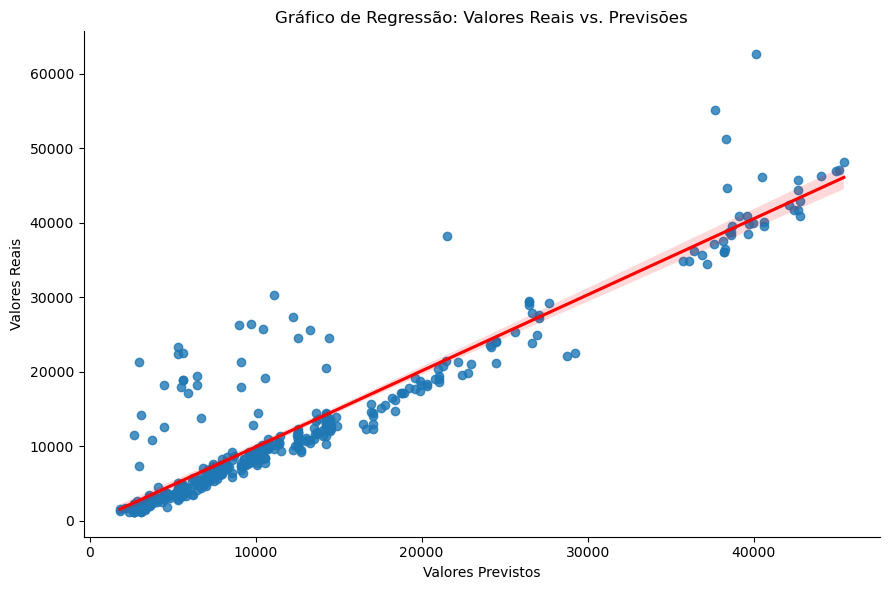

In [37]:
# plot regressão
df_resultados = pd.DataFrame({'y_real': y_teste, 'previsao': y_prev})

plt.figure(figsize=(8,6))
sns.lmplot(x='previsao', y='y_real', data=df_resultados, line_kws={'color': 'red'}, height=6, aspect=1.5)
plt.title('Gráfico de Regressão: Valores Reais vs. Previsões')
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.tight_layout()
plt.show()


In [39]:
# salvando modelo
import pickle
with open ('../models/model.pkl', 'wb') as f:
    pickle.dump(xgb, f)